<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTS1] - CNN with GTSRB dataset - Data analysis and preparation
<!-- DESC --> Episode 1 : Data analysis and creation of a usable dataset
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understand the **complexity associated with data**, even when it is only images
 - Learn how to build up a simple and **usable image dataset**

The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  

Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


## What we're going to do :

 - Understanding the dataset
 - Preparing and formatting enhanced data
 - Save enhanced datasets in h5 file format


## Step 1 -  Import and init

In [1]:
import os, time, sys
import csv
import math, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import io, color, exposure, transform

from importlib import reload

sys.path.append('..')
import fidle.pwk as ooo

place, datasets_dir = ooo.init()


FIDLE 2020 - Practical Work Module
Version              : 0.57 DEV
Run time             : Wednesday 9 September 2020, 15:23:48
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Current place        : Fidle at IDRIS
Dataset dir          : /gpfswork/rech/mlh/commun/datasets
Update keras cache   : Done


## Step 2 - Read the dataset
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
 - Each directory contains one CSV file with annotations ("GT-<ClassID>.csv") and the training images
 - First line is fieldnames: Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId  
    
### 2.1 - Understanding the dataset
The original dataset is in : **\<dataset_dir\>/origine.**  
There is 3 subsets : **Train**, **Test** and **Meta**.  
Each subset have an **csv file** and a **subdir**.
    

In [2]:
df = pd.read_csv(f'{datasets_dir}/GTSRB/origine/Test.csv', header=0)
display(df.head(10))

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
5,52,56,5,5,47,51,38,Test/00005.png
6,147,130,12,12,135,119,18,Test/00006.png
7,32,33,5,5,26,28,12,Test/00007.png
8,45,50,6,5,40,45,25,Test/00008.png
9,81,86,7,7,74,79,35,Test/00009.png


### 2.2 - Usefull functions
A nice function to read a subset...

In [3]:
def  read_csv_dataset(csv_file): 
    '''
    Reads traffic sign data from German Traffic Sign Recognition Benchmark dataset.
    Arguments:  
        csv filename :  Description file, Example /data/GTSRB/Train.csv
    Returns:
        x,y          :  np array of images, np array of corresponding labels
    '''

    path = os.path.dirname(csv_file)
    name = os.path.basename(csv_file)

    # ---- Read csv file
    #
    df = pd.read_csv(csv_file, header=0)
    
    # ---- Get filenames and ClassIds
    #
    filenames = df['Path'].to_list()
    y         = df['ClassId'].to_list()
    x         = []
    
    # ---- Read images
    #
    for filename in filenames:
        image=io.imread(f'{path}/{filename}')
        x.append(image)
        ooo.update_progress(name,len(x),len(filenames))
    
    # ---- Return
    #
    return np.array(x),np.array(y)

### 2.2 - Read the data
We will read the following datasets:
 - **x_train, y_train** : Learning data
 - **x_test, y_test** : Validation or test data
 - x_meta, y_meta : Illustration data
 
The learning data will be randomly mixted and the illustration data (Meta) sorted.  
Will take about 1'30s on HPC.

In [4]:
%%time

# ---- Read datasets

(x_train,y_train) = read_csv_dataset(f'{datasets_dir}/GTSRB/origine/Train.csv')
(x_test ,y_test)  = read_csv_dataset(f'{datasets_dir}/GTSRB/origine/Test.csv')
(x_meta ,y_meta)  = read_csv_dataset(f'{datasets_dir}/GTSRB/origine/Meta.csv')
    
# ---- Shuffle train set

combined = list(zip(x_train,y_train))
random.shuffle(combined)
x_train,y_train = zip(*combined)
x_train=np.array(x_train)
y_train=np.array(y_train)

# ---- Sort Meta

combined = list(zip(x_meta,y_meta))
combined.sort(key=lambda x: x[1])
x_meta,y_meta = zip(*combined)

Train.csv        [########################################] 100.0% of 39209
Test.csv         [########################################] 100.0% of 12630
Meta.csv         [########################################] 100.0% of 43
CPU times: user 20 s, sys: 4.27 s, total: 24.3 s
Wall time: 35.8 s


## Step 3 - Few statistics about train dataset
We want to know if our images are homogeneous in terms of size, ratio, width or height.

### 3.1 - Do statistics 

In [5]:
train_size  = []
train_ratio = []
train_lx    = []
train_ly    = []

test_size   = []
test_ratio  = []
test_lx     = []
test_ly     = []

for image in x_train:
    (lx,ly,lz) = image.shape
    train_size.append(lx*ly/1024)
    train_ratio.append(lx/ly)
    train_lx.append(lx)
    train_ly.append(ly)

for image in x_test:
    (lx,ly,lz) = image.shape
    test_size.append(lx*ly/1024)
    test_ratio.append(lx/ly)
    test_lx.append(lx)
    test_ly.append(ly)

### 3.2 - Show statistics

x_train shape :  (39209,)
y_train shape :  (39209,)
x_test  shape :  (12630,)
y_test  shape :  (12630,)


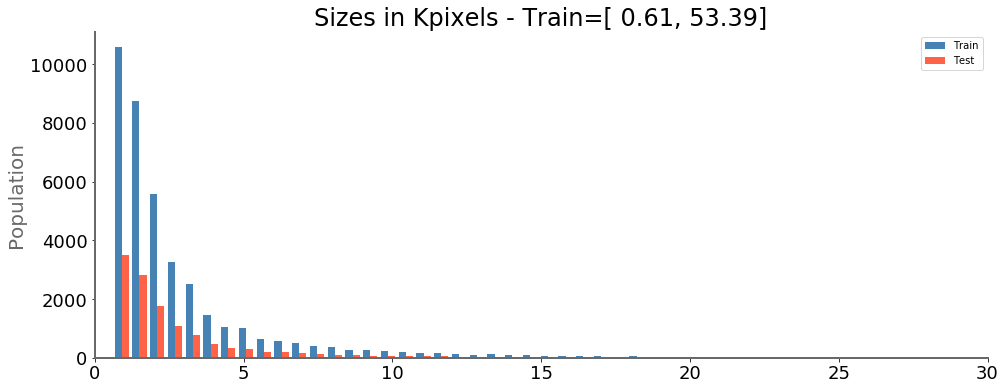

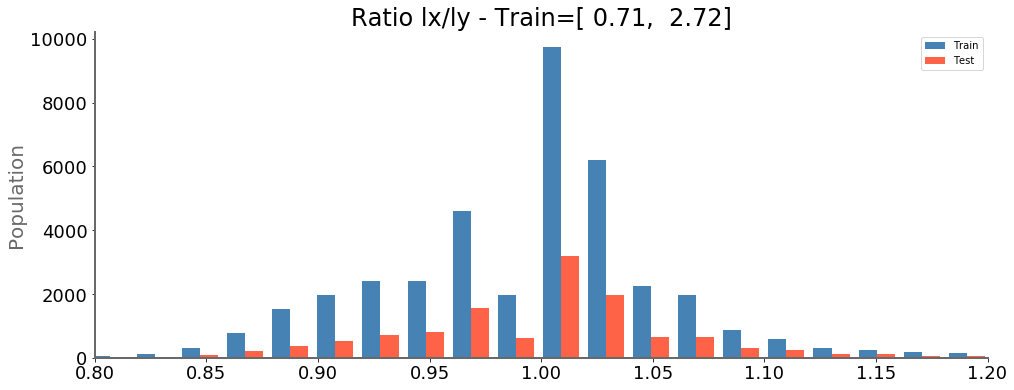

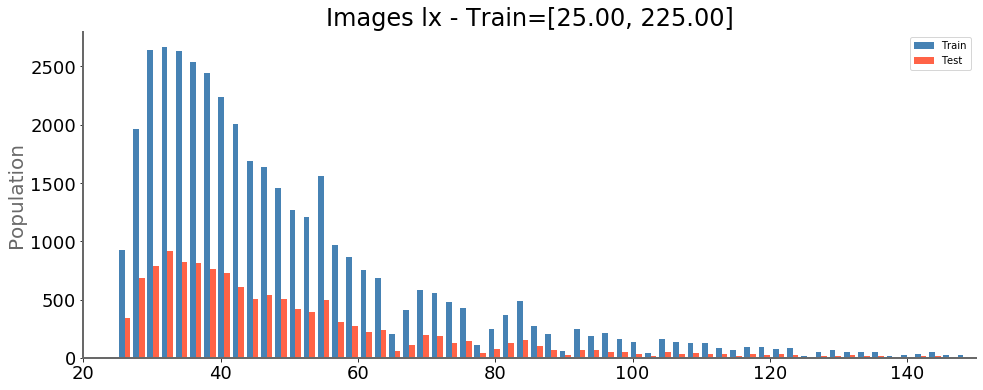

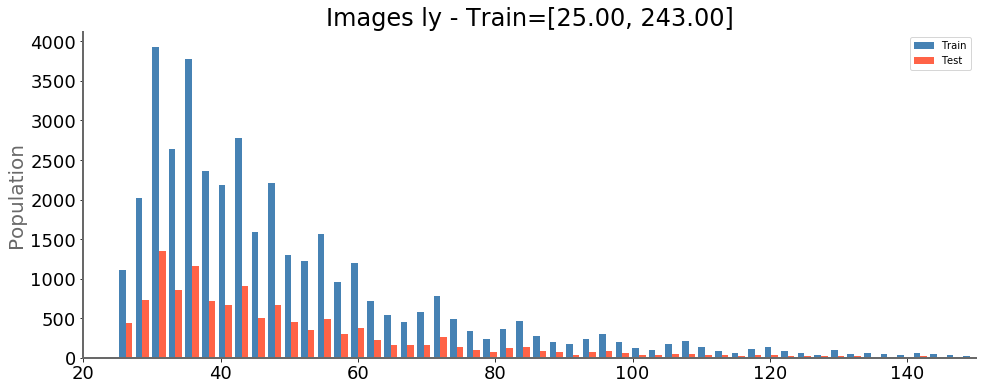

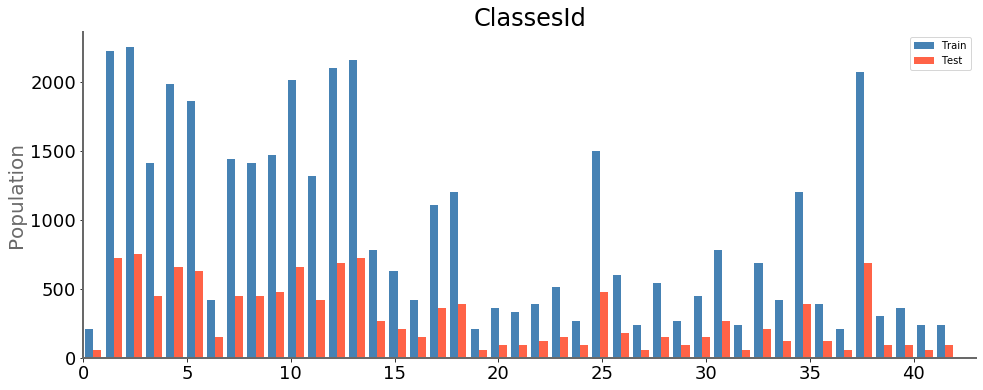

In [6]:
# ------ Global stuff
print("x_train shape : ",x_train.shape)
print("y_train shape : ",y_train.shape)
print("x_test  shape : ",x_test.shape)
print("y_test  shape : ",y_test.shape)

# ------ Statistics / sizes
plt.figure(figsize=(16,6))
plt.hist([train_size,test_size], bins=100)
plt.gca().set(title='Sizes in Kpixels - Train=[{:5.2f}, {:5.2f}]'.format(min(train_size),max(train_size)), 
              ylabel='Population',
              xlim=[0,30])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / ratio lx/ly
plt.figure(figsize=(16,6))
plt.hist([train_ratio,test_ratio], bins=100)
plt.gca().set(title='Ratio lx/ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ratio),max(train_ratio)), 
              ylabel='Population',
              xlim=[0.8,1.2])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / lx
plt.figure(figsize=(16,6))
plt.hist([train_lx,test_lx], bins=100)
plt.gca().set(title='Images lx - Train=[{:5.2f}, {:5.2f}]'.format(min(train_lx),max(train_lx)), 
              ylabel='Population',
              xlim=[20,150])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / ly
plt.figure(figsize=(16,6))
plt.hist([train_ly,test_ly], bins=100)
plt.gca().set(title='Images ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ly),max(train_ly)), 
              ylabel='Population',
              xlim=[20,150])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / classId
plt.figure(figsize=(16,6))
plt.hist([y_train,y_test], bins=43)
plt.gca().set(title='ClassesId', 
              ylabel='Population',
              xlim=[0,43])
plt.legend(['Train','Test'])
plt.show()

## Step 4 - List of classes
What are the 43 classes of our images...

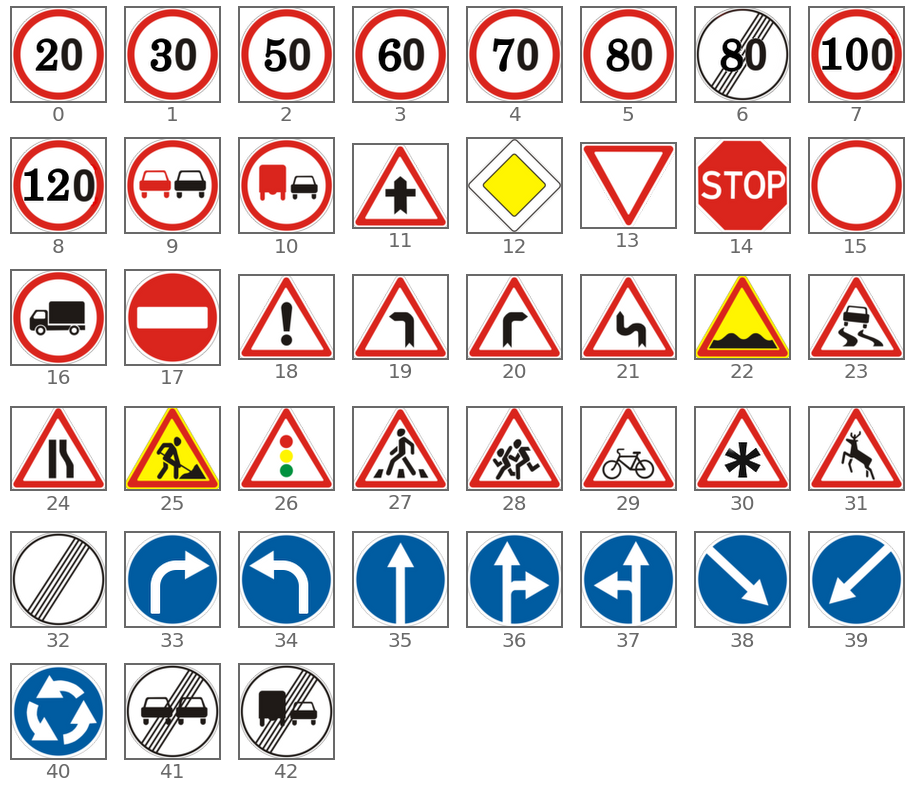

In [7]:
ooo.plot_images(x_meta,y_meta, range(43), columns=8, x_size=2, y_size=2, 
                                colorbar=False, y_pred=None, cm='binary')

## Step 5 - What does it really look like

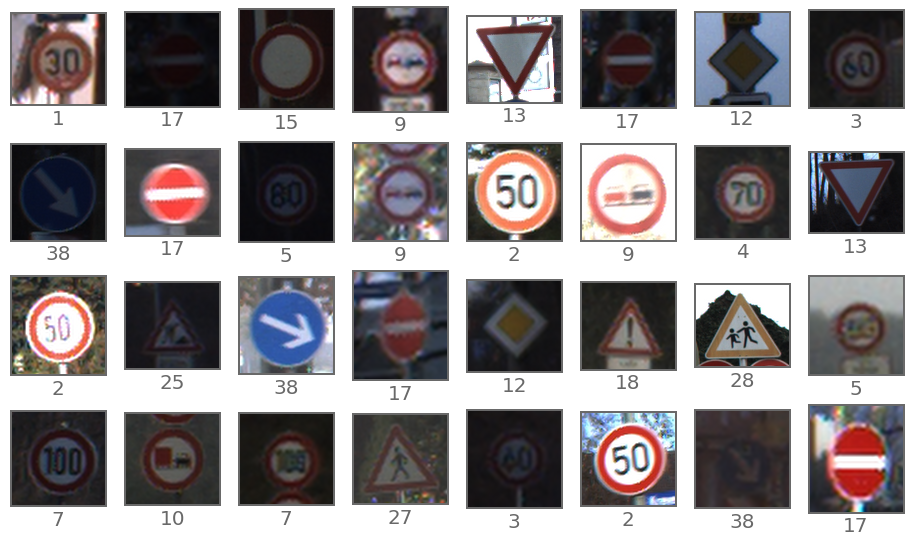

In [8]:
# ---- Get and show few images

samples = [ random.randint(0,len(x_train)-1) for i in range(32)]
ooo.plot_images(x_train,y_train, samples, columns=8, x_size=2, y_size=2, colorbar=False, y_pred=None, cm='binary')


## Step 6 - dataset cooking...

Images **must** :
 - have the **same size** to match the size of the network,
 - be **normalized**.  
 
It is possible to work on **rgb** or **monochrome** images and to **equalize** the histograms.   

See : [Exposure with scikit-image](https://scikit-image.org/docs/dev/api/skimage.exposure.html)  
See : [Local histogram equalization](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.equalize)  
See : [Histogram equalization](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist)  

### 6.1 - Enhancement cook

In [9]:
def images_enhancement(images, width=25, height=25, mode='RGB'):
    '''
    Resize and convert images - doesn't change originals.
    input images must be RGBA or RGB.
    args:
        images :         images list
        width,height :   new images size (25,25)
        mode :           RGB | RGB-HE | L | L-HE | L-LHE | L-CLAHE
    return:
        numpy array of enhanced images
    '''
    modes = { 'RGB':3, 'RGB-HE':3, 'L':1, 'L-HE':1, 'L-LHE':1, 'L-CLAHE':1}
    lz=modes[mode]
    
    out=[]
    for img in images:
        
        # ---- if RGBA, convert to RGB
        if img.shape[2]==4:
            img=color.rgba2rgb(img)
            
        # ---- Resize
        img = transform.resize(img, (width,height))

        # ---- RGB / Histogram Equalization
        if mode=='RGB-HE':
            hsv = color.rgb2hsv(img.reshape(width,height,3))
            hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
            img = color.hsv2rgb(hsv)
        
        # ---- Grayscale
        if mode=='L':
            img=color.rgb2gray(img)
            
        # ---- Grayscale / Histogram Equalization
        if mode=='L-HE':
            img=color.rgb2gray(img)
            img=exposure.equalize_hist(img)
            
        # ---- Grayscale / Local Histogram Equalization
        if mode=='L-LHE':        
            img=color.rgb2gray(img)
            img = img_as_ubyte(img)
            img=rank.equalize(img, disk(10))/255.
        
        # ---- Grayscale / Contrast Limited Adaptive Histogram Equalization (CLAHE)
        if mode=='L-CLAHE':
            img=color.rgb2gray(img)
            img=exposure.equalize_adapthist(img)
            
        # ---- Add image in list of list
        out.append(img)
        ooo.update_progress('Enhancement: ',len(out),len(images))

    # ---- Reshape images
    #     (-1, width,height,1) for L
    #     (-1, width,height,3) for RGB
    #
    out = np.array(out,dtype='float64')
    out = out.reshape(-1,width,height,lz)
    return out

### 6.2 - To get an idea of the different recipes

Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16


#### EXPECTED

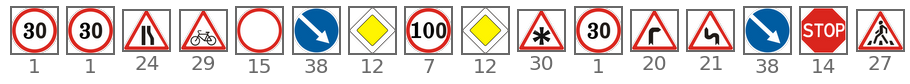

#### ORIGINAL

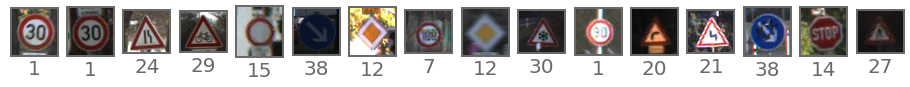

#### ENHANCED

dataset : RGB  min,max=[0.027,0.999]  shape=(16, 25, 25, 3)


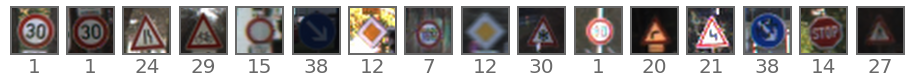

dataset : RGB-HE  min,max=[0.001,1.000]  shape=(16, 25, 25, 3)


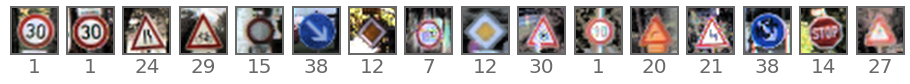

dataset : L  min,max=[0.032,0.998]  shape=(16, 25, 25, 1)


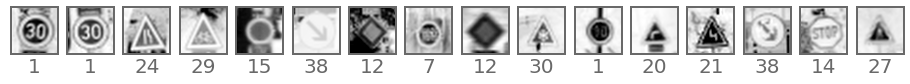

dataset : L-HE  min,max=[0.002,1.000]  shape=(16, 25, 25, 1)


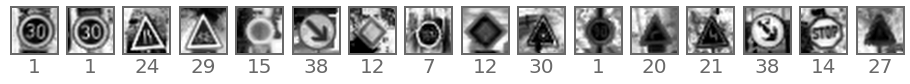

dataset : L-LHE  min,max=[0.000,1.000]  shape=(16, 25, 25, 1)


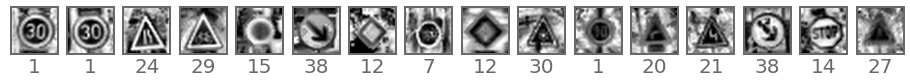

dataset : L-CLAHE  min,max=[0.000,1.000]  shape=(16, 25, 25, 1)


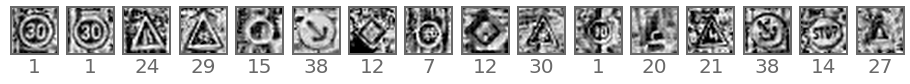

In [10]:
i=random.randint(0,len(x_train)-16)
x_samples = x_train[i:i+16]
y_samples = y_train[i:i+16]

datasets  = {}

datasets['RGB']      = images_enhancement( x_samples, width=25, height=25, mode='RGB'  )
datasets['RGB-HE']   = images_enhancement( x_samples, width=25, height=25, mode='RGB-HE'  )
datasets['L']        = images_enhancement( x_samples, width=25, height=25, mode='L'  )
datasets['L-HE']     = images_enhancement( x_samples, width=25, height=25, mode='L-HE'  )
datasets['L-LHE']    = images_enhancement( x_samples, width=25, height=25, mode='L-LHE'  )
datasets['L-CLAHE']  = images_enhancement( x_samples, width=25, height=25, mode='L-CLAHE'  )

ooo.display_md('#### EXPECTED')
x_expected=[ x_meta[i] for i in y_samples]
ooo.plot_images(x_expected, y_samples, range(16), columns=16, x_size=1, y_size=1, colorbar=False, y_pred=None, cm='binary')

ooo.display_md('#### ORIGINAL')
ooo.plot_images(x_samples,  y_samples, range(16), columns=16, x_size=1, y_size=1, colorbar=False, y_pred=None, cm='binary')

ooo.display_md('#### ENHANCED')
for k,d in datasets.items():
    print("dataset : {}  min,max=[{:.3f},{:.3f}]  shape={}".format(k,d.min(),d.max(), d.shape))
    ooo.plot_images(d, y_samples, range(16), columns=16, x_size=1, y_size=1, colorbar=False, y_pred=None, cm='binary')


### 6.3 - Cook and save
A function to save a dataset

In [11]:
def save_h5_dataset(x_train, y_train, x_test, y_test, x_meta,y_meta, h5name):
    
    # ---- Create h5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("x_train", data=x_train)
        f.create_dataset("y_train", data=y_train)
        f.create_dataset("x_test",  data=x_test)
        f.create_dataset("y_test",  data=y_test)
        f.create_dataset("x_meta",  data=x_meta)
        f.create_dataset("y_meta",  data=y_meta)
        
    # ---- done
    size=os.path.getsize(filename)/(1024*1024)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)\n'.format(filename, str(x_train.shape),size))

<div class='todo'>
    Create enhanced datasets and save them will take about 7-8' and using about 9 GB<br>
    To perform tests, change the code below to use :
    <li> a local folder (./data),
    <li>a subset of the dataset, for example 2000 images.
</div>

In [12]:
%%time

# ---- Uncomment to write h5 datasets in the project place
#
#output_dir = datasets_dir   PLEASE, DON'T DO THIS DURING THE COURSE ;-) !

# ---- Uncomment to write h5 datasets in a local ./data for tests
#      For small test only !  (only 500 images)
#
output_dir = './data'
ooo.mkdir(output_dir)

for s in [24, 48]:
    for m in ['RGB', 'RGB-HE', 'L', 'L-LHE']:
        # ---- A nice dataset name
        filename = f'{output_dir}/set-{s}x{s}-{m}.h5'
        print("\nDataset : ",filename)
        # ---- Enhancement
        x_train_new = images_enhancement( x_train[:500], width=s, height=s, mode=m )
        x_test_new  = images_enhancement( x_test[:500],  width=s, height=s, mode=m )
        x_meta_new  = images_enhancement( x_meta,  width=s, height=s, mode='RGB' )
        # ---- Save
        save_h5_dataset( x_train_new, y_train, x_test_new, y_test, x_meta_new,y_meta, filename)

x_train_new,x_test_new=0,0



Dataset :  ./data/set-24x24-RGB.h5
Enhancement:     [########################################] 100.0% of 500
Enhancement:     [########################################] 100.0% of 500
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-RGB.h5   shape : (500, 24, 24, 3)       size :   14.2 Mo   (saved)


Dataset :  ./data/set-24x24-RGB-HE.h5
Enhancement:     [########################################] 100.0% of 500
Enhancement:     [########################################] 100.0% of 500
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-RGB-HE.h5  shape : (500, 24, 24, 3)       size :   14.2 Mo   (saved)


Dataset :  ./data/set-24x24-L.h5
Enhancement:     [########################################] 100.0% of 500
Enhancement:     [########################################] 100.0% of 500
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-L.h5     

<div class='todo'>
  Adapt the code below to read :
  <ul>
      <li>the different h5 datasets you saved in ./data,</li>
      <li>The h5 datasets available in the Fidle project datasets directory.</li>
  </ul>
 
</div>

## Step 7 - Reload data to be sure ;-)

dataset loaded from h5 file.


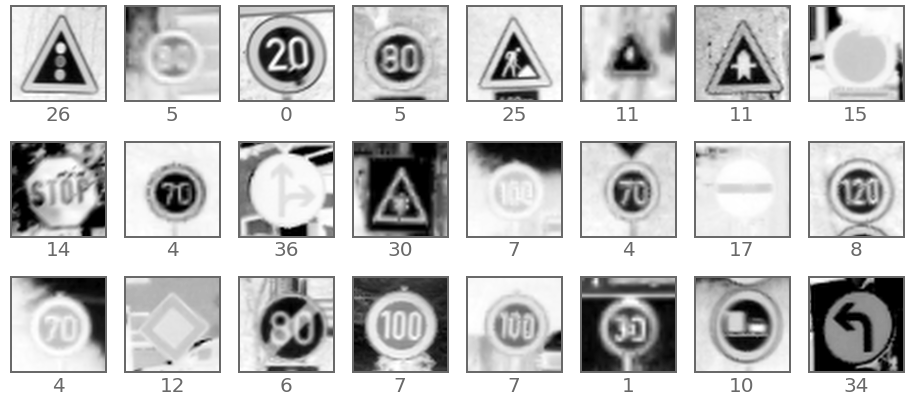

CPU times: user 995 ms, sys: 7.27 ms, total: 1 s
Wall time: 1.01 s


In [13]:
%%time

dataset='set-48x48-L'
samples=range(24)

with  h5py.File(f'{output_dir}/{dataset}.h5','r') as f:
    x_tmp = f['x_train'][:]
    y_tmp = f['y_train'][:]
    print("dataset loaded from h5 file.")

ooo.plot_images(x_tmp,y_tmp, samples, columns=8, x_size=2, y_size=2, colorbar=False, y_pred=None, cm='binary')
x_tmp,y_tmp=0,0

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>